In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
N,C = 3,3
X_train,Y_train = [],[]
a,b = np.random.randint(0, 2**N, size=(2,10000))
c = a+b
c = c & (2**N-1)
X_train = (a << N) | b
Y_train = c

In [43]:
class QuantumOperator(keras.layers.Layer):
    
    def __init__(self, qubits, unitary_loss_factor=1., prob_loss_factor=1., **kwargs):
        self.dimension = 2**qubits
        self.unitary_loss_factor = unitary_loss_factor
        self.prob_loss_factor = prob_loss_factor
        super(QuantumOperator, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.operator_real = self.add_weight(
            shape=(self.dimension, self.dimension),
            initializer='glorot_normal', name='operator_real')
        self.operator_imag = self.add_weight(
            shape=(self.dimension, self.dimension),
            initializer='glorot_normal', name='operator_imag')
        super().build(input_shape)
    
    def call(self, inputs):
        operator = tf.complex(self.operator_real, self.operator_imag)
        forward = inputs @ operator
        reverse = forward @ tf.conj(tf.transpose(operator))
        prob = K.square(tf.abs(forward))
        self.add_loss(self.unitary_loss_factor/2 * K.sum(keras.losses.mae(
            tf.real(inputs), tf.real(reverse))), inputs=inputs)
        self.add_loss(self.unitary_loss_factor/2 * K.sum(keras.losses.mae(
            tf.imag(inputs), tf.imag(reverse))), inputs=inputs)
        self.add_loss(self.prob_loss_factor * K.sum(keras.losses.mae(
            1., K.sum(prob, axis=-1))), inputs=inputs)
        return forward
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimension)

In [44]:
X = X_input = keras.layers.Input((1,), dtype='int32')
X = keras.layers.Lambda(lambda x: tf.complex(
    K.squeeze(K.one_hot(K.cast(x, 'int32'), 2**int(round(C*N))), axis=-2), 0.))(X)
X_operator = QuantumOperator(int(round(C*N)))
X = X_operator(X)
X = keras.layers.Lambda(lambda x: K.square(tf.abs(x)))(X)
X = keras.layers.Lambda(lambda x: K.sum(K.reshape(x,(-1,2**int(round((C-1)*N)),2**N)), axis=-2))(X)
M = keras.Model(X_input, X)
M_opt = keras.optimizers.SGD(momentum=0.9, nesterov=True)
M.compile('nadam', 'sparse_categorical_crossentropy')
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
lambda_34 (Lambda)           (None, 512)               0         
_________________________________________________________________
quantum_operator_12 (Quantum (None, 512)               524288    
_________________________________________________________________
lambda_35 (Lambda)           (None, 512)               0         
_________________________________________________________________
lambda_36 (Lambda)           (None, 8)                 0         
Total params: 524,288
Trainable params: 524,288
Non-trainable params: 0
_________________________________________________________________


In [48]:
M.fit(X_train, Y_train, epochs=100, batch_size=128, callbacks=[
    keras.callbacks.ReduceLROnPlateau('loss', patience=3, min_delta=0., verbose=1),
])

Epoch 1/100
10000/10000 [==============================] - 1s 127us/step - loss: 0.0877
Epoch 2/100
10000/10000 [==============================] - 1s 129us/step - loss: 0.0859
Epoch 3/100
10000/10000 [==============================] - 1s 129us/step - loss: 0.0869
Epoch 4/100
10000/10000 [==============================] - 1s 128us/step - loss: 0.0841
Epoch 5/100
10000/10000 [==============================] - 1s 127us/step - loss: 0.0855
Epoch 6/100
10000/10000 [==============================] - 1s 127us/step - loss: 0.0827
Epoch 7/100
10000/10000 [==============================] - 1s 126us/step - loss: 0.0840
Epoch 8/100
10000/10000 [==============================] - 1s 127us/step - loss: 0.0845
Epoch 9/100
10000/10000 [==============================] - 1s 127us/step - loss: 0.0838

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 10/100
10000/10000 [==============================] - 1s 127us/step - loss: 0.0158
Epoch 11/100
10000/10000 [===========

10000/10000 [==============================] - 1s 128us/step - loss: 8.6804e-07
Epoch 84/100
10000/10000 [==============================] - 1s 127us/step - loss: 8.6716e-07

Epoch 00084: ReduceLROnPlateau reducing learning rate to 2.000000165480742e-11.
Epoch 85/100
10000/10000 [==============================] - 1s 127us/step - loss: 8.6776e-07
Epoch 86/100
10000/10000 [==============================] - 1s 127us/step - loss: 8.7014e-07
Epoch 87/100
10000/10000 [==============================] - 1s 128us/step - loss: 8.7242e-07

Epoch 00087: ReduceLROnPlateau reducing learning rate to 2.000000165480742e-12.
Epoch 88/100
10000/10000 [==============================] - 1s 128us/step - loss: 8.7346e-07
Epoch 89/100
10000/10000 [==============================] - 1s 127us/step - loss: 8.7363e-07
Epoch 90/100
10000/10000 [==============================] - 1s 127us/step - loss: 8.7388e-07

Epoch 00090: ReduceLROnPlateau reducing learning rate to 2.000000208848829e-13.
Epoch 91/100
10000/10000 [

In [49]:
operator = X_operator.get_weights()
operator = operator[0].T + operator[1].T*1j

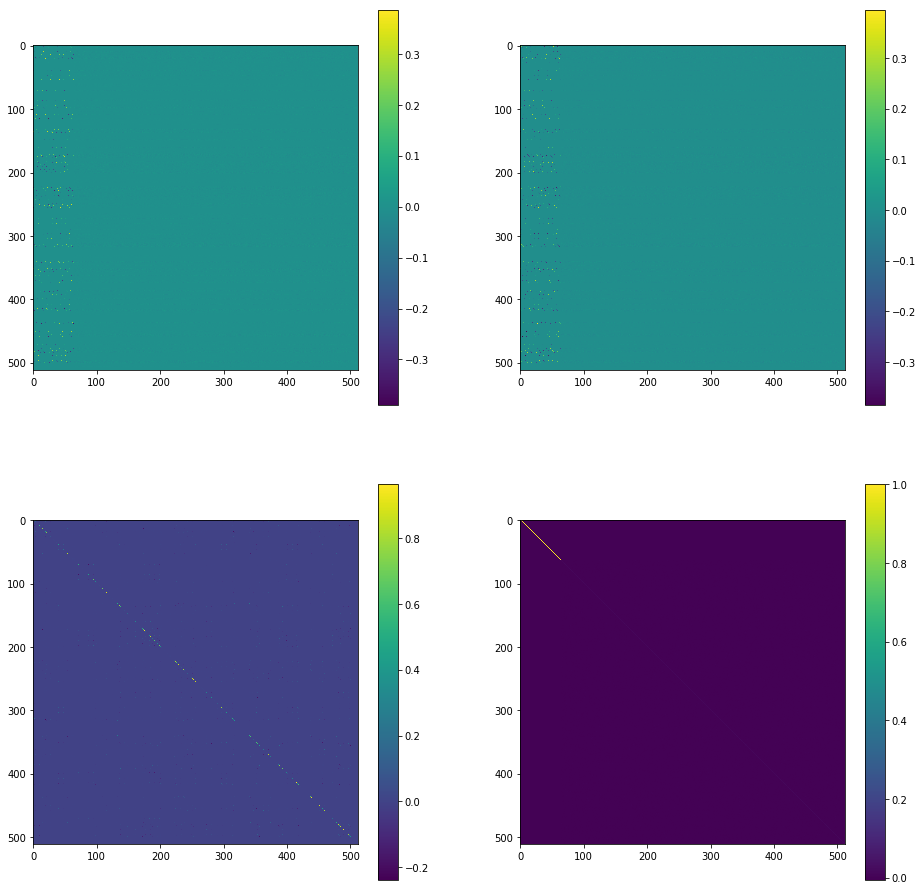

In [58]:
plt.figure(figsize=(16,16))
plt.subplot(2,2,1)
plt.imshow(np.real(operator))
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(np.imag(operator))
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(np.real(operator @ np.conj(operator.T)))
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(np.real(np.conj(operator.T) @ operator))
plt.colorbar()
plt.show()

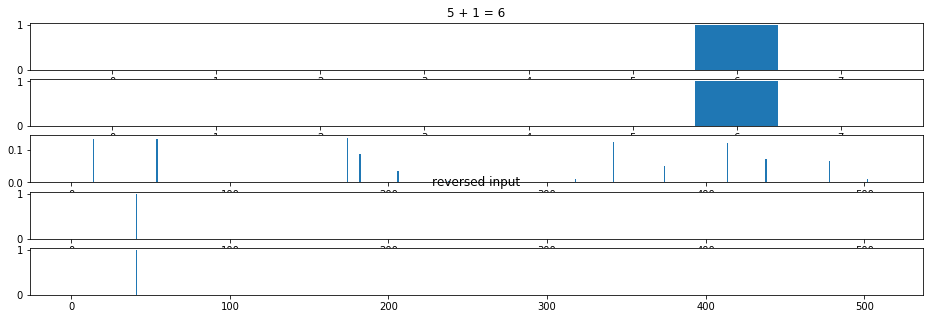

max prob by the regressed operator: 174 , sum of prob: 1.0


In [56]:
i = np.random.randint(0,len(X_train))
s = (operator @ keras.utils.to_categorical(X_train[i], num_classes=2**int(round(C*N))))
x = np.square(np.abs(np.conj(operator.T) @ s))
y = np.square(np.abs(s))
y_sum = np.sum(np.reshape(y,(2**int(round((C-1)*N)),2**N)), axis=-2)
plt.figure(figsize=(16,5))
plt.subplot(5,1,1)
plt.title(f'{a[i]} + {b[i]} = {c[i]}')
plt.bar(np.arange(2**N), y_sum)
plt.subplot(5,1,2)
plt.bar(np.arange(2**N), keras.utils.to_categorical(Y_train[i], num_classes=2**N))
plt.subplot(5,1,3)
plt.bar(np.arange(2**int(round(C*N))), y)
plt.subplot(5,1,4)
plt.title('reversed input')
plt.bar(np.arange(2**int(round(C*N))), x)
plt.subplot(5,1,5)
plt.bar(np.arange(2**int(round(C*N))), keras.utils.to_categorical(X_train[i], num_classes=2**int(round(C*N))))
plt.show()
print('max prob by the regressed operator:', np.argmax(y), ', sum of prob:', np.sum(y))

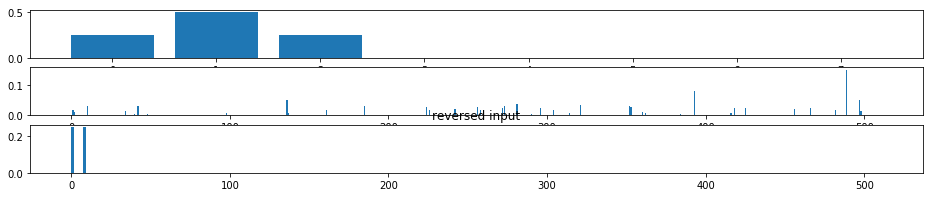

max prob by the regressed operator: 489 , sum of prob: 1.0000000505856272


In [57]:
s = np.zeros((2**int(round(C*N)),))
s[(0 << N) | 1] = 1./np.sqrt(4)
s[(0 << N) | 0] = 1./np.sqrt(4)
s[(1 << N) | 1] = 1./np.sqrt(4)
s[(1 << N) | 0] = 1./np.sqrt(4)
s = (operator @ s)
x = np.square(np.abs(np.conj(operator.T) @ s))
y = np.square(np.abs(s))
y_sum = np.sum(np.reshape(y,(2**int(round((C-1)*N)),2**N)), axis=-2)
plt.figure(figsize=(16,3))
plt.subplot(3,1,1)
plt.bar(np.arange(2**N), y_sum)
plt.subplot(3,1,2)
plt.bar(np.arange(2**int(round(C*N))), y)
plt.subplot(3,1,3)
plt.title('reversed input')
plt.bar(np.arange(2**int(round(C*N))), x)
plt.show()
print('max prob by the regressed operator:', np.argmax(y), ', sum of prob:', np.sum(y))